In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
import os
import sys

In [ ]:
inference_df = pd.read_csv("obf_proguard_dpd/DPD_Att_inf_data.csv")
inference_df.head(40)

,Directory,SourceFile,ObfDirectory,DesignPattern
0,cucumber-jvm,SingletonFactory,obfu,Singleton
1,robo-remote,EmSingleton,obfu2,Singleton
2,hivedb,SingletonHiveSessionFactoryBuilder,obfu29,Singleton
3,jbehave-core,WeldStepsFactory,obfu3,AbstractFactory
4,ASEME,SRMFactory,obfu4,AbstractFactory
5,cayenne,WidgetFactory,obfu5,AbstractFactory
6,pcgen-svn,ListDataAdapter,obfu7,Adapter
7,adapt,SakaiAdapter,obfu8,Adapter
8,cdt,TextViewerDragAdapter,obfu9,Adapter
9,jbehave-core,PicoAnnotationBuilder,obfu10,Builder


In [3]:

# Load your LabelEncoder from training
label_encoder = LabelEncoder()
# Fit the label encoder with the same labels used during training
label_encoder.classes_ = np.load('label_classes.npy', allow_pickle=True)

label_encoder.classes_ 

array(['AbstractFactory', 'Adapter', 'Builder', 'Decorator', 'Facade',
       'FactoryMethod', 'Memento', 'Observer', 'Prototype', 'Proxy',
       'Singleton', 'Strategy', 'Unknown', 'Visitor'], dtype=object)

In [4]:
feature_names = joblib.load("feature_names.pkl")
print(feature_names)

Index(['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4',
       'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9',
       ...
       'Feature_246', 'Feature_247', 'Feature_248', 'Feature_249',
       'Feature_250', 'Feature_251', 'Feature_252', 'Feature_253',
       'Feature_254', 'Feature_255'],
      dtype='object', length=256)


In [5]:
# Load classifiers from files
classifiers = {
    'SVM': joblib.load('cross_valid_model_256/Support_Vector_Machine.pkl'),
    'Logistic Regression': joblib.load('cross_valid_model_256/Logistic_Regression.pkl'),
    'MLP': joblib.load('cross_valid_model_256/Multi-layer_Perceptron.pkl')
}

In [9]:
# Import the encode_java_code function from embeddings.py
from embeddings import encode_java_code

In [7]:
# Add new columns for predictions
inference_df["Obfuscated_SVM"] = ""
inference_df["Obfuscated_Logistic Regression"] = ""
inference_df["Obfuscated_MLP"] = ""

In [10]:
# Perform inference
for idx, row in inference_df.iterrows():
    directory = row['Directory']
    source_file = row['SourceFile']
    obf_directory = row['ObfDirectory']
    design_pattern = row['DesignPattern']
    
    # Construct source file path
    source_path = os.path.join("obf_proguard_dpd4", obf_directory, "src", f"{source_file}.java")
    
    # Find the single obfuscated file in the decompiled_file folder
    obf_folder = os.path.join("obf_proguard_dpd4", obf_directory, "decompiled_file")
    obf_files = [f for f in os.listdir(obf_folder) if f.endswith(".java")]
    
    if len(obf_files) != 1:
        print(f"Expected exactly one obfuscated .java file in {obf_folder}, found: {obf_files}")
        continue
    
    obf_path = os.path.join(obf_folder, obf_files[0])
    
    # Check if source file exists
    if not os.path.exists(source_path):
        print(f"Source file not found: {source_path}")
        continue
    
    # Helper function to perform predictions
    def get_predictions(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            java_code = f.read()
        embedding = encode_java_code(java_code).tolist()
        row_vector = np.array(embedding).reshape(1, -1)
        
        # Add feature names for compatibility with the trained model
        feature_df = pd.DataFrame(row_vector, columns=feature_names)
        
        # Get predictions for all classifiers
        predictions = {}
        for name, classifier in classifiers.items():
            prediction = classifier.predict(feature_df)
            decoded_prediction = label_encoder.inverse_transform([prediction[0]])[0]
            predictions[name] = decoded_prediction
        return predictions
    
    # Perform predictions for obfuscated files
    obfuscated_predictions = get_predictions(obf_path)
    
    # Update the DataFrame with predictions
    inference_df.at[idx, "Obfuscated_SVM"] = obfuscated_predictions["SVM"]
    inference_df.at[idx, "Obfuscated_Logistic Regression"] = obfuscated_predictions["Logistic Regression"]
    inference_df.at[idx, "Obfuscated_MLP"] = obfuscated_predictions["MLP"]

# Save results to CSV
results_csv = "inference_results_CV_7_34.csv"
inference_df.to_csv(results_csv, index=False)
print(f"Inference completed. Results saved to {results_csv}.")

Inference completed. Results saved to inference_results_CV_7_34.csv.


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the test set
test_df = pd.read_csv("obf_classifier_34.csv")

# Prepare features and labels
X_test = test_df[[f"Feature_{i}" for i in range(256)]].values
y_test = test_df["DesignPattern"].values

# Load label encoder (must match the one used in training)
label_encoder = joblib.load("label_encoder.pkl") if os.path.exists("label_encoder.pkl") else None
if label_encoder is None:
    # fallback: try numpy file
    label_encoder = joblib.load("cross_valid_model_256/label_encoder.pkl") if os.path.exists("cross_valid_model_256/label_encoder.pkl") else None
if label_encoder is None:
    import numpy as np
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.load('label_classes.npy', allow_pickle=True)

# Encode y_test if needed
if not np.issubdtype(y_test.dtype, np.integer):
    y_test_enc = label_encoder.transform(y_test)
else:
    y_test_enc = y_test

# Load classifiers
models = {
    "SVM": joblib.load("cross_valid_model_256/Support_Vector_Machine.pkl"),
    "Logistic Regression": joblib.load("cross_valid_model_256/Logistic_Regression.pkl"),
    "MLP": joblib.load("cross_valid_model_256/Multi-layer_Perceptron.pkl")
}

# Evaluate each model
results = []
for name, clf in models.items():
    y_pred = clf.predict(X_test)
    # If predictions are encoded, decode for reporting
    try:
        y_pred_label = label_encoder.inverse_transform(y_pred)
    except Exception:
        y_pred_label = y_pred
    acc = accuracy_score(y_test, y_pred_label)
    prec = precision_score(y_test, y_pred_label, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred_label, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred_label, average='macro', zero_division=0)
    results.append({
        "Classifier": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

# Show results
results_df = pd.DataFrame(results)
display(results_df)

c:\Users\ms84\AppData\Local\miniconda3\envs\venv_dpd\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



SVM Classification Report:
                 precision    recall  f1-score   support

AbstractFactory       0.00      0.00      0.00         3
        Adapter       1.00      0.33      0.50         3
        Builder       0.29      0.67      0.40         3
      Decorator       0.00      0.00      0.00         2
         Facade       0.00      0.00      0.00         2
  FactoryMethod       0.00      0.00      0.00         2
        Memento       0.00      0.00      0.00         2
       Observer       0.00      0.00      0.00         2
      Prototype       0.06      0.50      0.10         2
          Proxy       0.00      0.00      0.00         2
      Singleton       0.00      0.00      0.00         3
       Strategy       0.00      0.00      0.00         3
        Unknown       0.20      0.50      0.29         2
        Visitor       1.00      0.33      0.50         3

       accuracy                           0.18        34
      macro avg       0.18      0.17      0.13        34
 

c:\Users\ms84\AppData\Local\miniconda3\envs\venv_dpd\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Logistic Regression Classification Report:
                 precision    recall  f1-score   support

AbstractFactory       0.00      0.00      0.00         3
        Adapter       0.00      0.00      0.00         3
        Builder       0.50      0.67      0.57         3
      Decorator       0.00      0.00      0.00         2
         Facade       0.00      0.00      0.00         2
  FactoryMethod       0.00      0.00      0.00         2
        Memento       0.00      0.00      0.00         2
       Observer       0.00      0.00      0.00         2
      Prototype       0.09      1.00      0.17         2
          Proxy       0.00      0.00      0.00         2
      Singleton       0.00      0.00      0.00         3
       Strategy       0.00      0.00      0.00         3
        Unknown       0.00      0.00      0.00         2
        Visitor       0.50      0.33      0.40         3

       accuracy                           0.15        34
      macro avg       0.08      0.14      

c:\Users\ms84\AppData\Local\miniconda3\envs\venv_dpd\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



MLP Classification Report:
                 precision    recall  f1-score   support

AbstractFactory       1.00      0.33      0.50         3
        Adapter       1.00      0.33      0.50         3
        Builder       0.33      0.67      0.44         3
      Decorator       0.00      0.00      0.00         2
         Facade       0.00      0.00      0.00         2
  FactoryMethod       0.00      0.00      0.00         2
        Memento       0.00      0.00      0.00         2
       Observer       0.00      0.00      0.00         2
      Prototype       0.00      0.00      0.00         2
          Proxy       0.00      0.00      0.00         2
      Singleton       0.00      0.00      0.00         3
       Strategy       0.00      0.00      0.00         3
        Unknown       0.00      0.00      0.00         2
        Visitor       0.33      0.33      0.33         3

       accuracy                           0.15        34
      macro avg       0.19      0.12      0.13        34
 

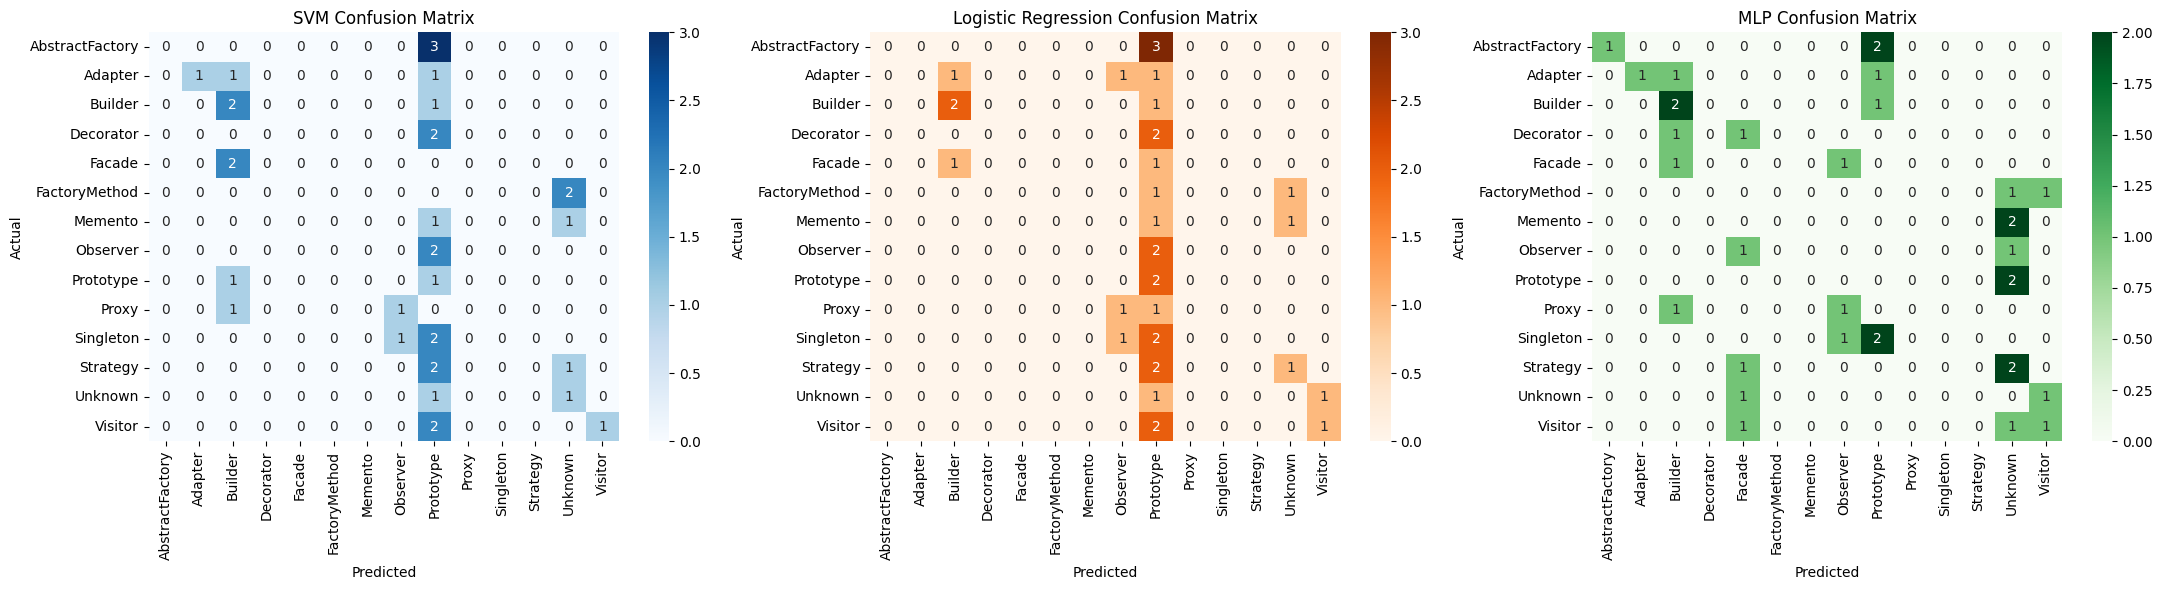

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report and plot confusion matrix for each model
colormaps = ['Blues', 'Oranges', 'Greens']
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

for i, (name, clf) in enumerate(models.items()):
    y_pred = clf.predict(X_test)
    # Decode predictions if needed
    try:
        y_pred_label = label_encoder.inverse_transform(y_pred)
    except Exception:
        y_pred_label = y_pred

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred_label, target_names=label_encoder.classes_, zero_division=0))
    print('-' * 30)

    # Confusion matrix as heatmap
    cm = confusion_matrix(y_test, y_pred_label, labels=label_encoder.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap=colormaps[i], 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[i])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the inference results
inference_data = pd.read_csv("inference_results_CV_7_34.csv")

# List of classifiers and their columns
classifiers = [
    ('SVM', 'Obfuscated_SVM'),
    ('Logistic Regression', 'Obfuscated_Logistic Regression'),
    ('MLP',  'Obfuscated_MLP')
]

# Function to compute metrics
def compute_metrics(true_labels, pred_labels, average='macro'):
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average=average, zero_division=0)
    recall = recall_score(true_labels, pred_labels, average=average, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average=average, zero_division=0)
    return accuracy, precision, recall, f1

results = []

for clf_name,  obf_col in classifiers:
    # For original classifiers (source predictions vs. ground truth)
    y_true = inference_data['DesignPattern']
 
    
    # For obfuscated classifiers (obfuscated predictions vs. ground truth)
    y_pred_obf = inference_data[obf_col]
    acc_obf, prec_obf, rec_obf, f1_obf = compute_metrics(y_true, y_pred_obf)
    
    results.append({
        'Classifier': clf_name,
        'Obfuscated_Accuracy (34 files)': acc_obf,
        'Obfuscated_Precision (34 files)': prec_obf,
        'Obfuscated_Recall (34 files)': rec_obf,
        'Obfuscated_F1 (34 files)': f1_obf
    })

# Display results as a DataFrame
metrics_df = pd.DataFrame(results)
metrics_df.head()

,Classifier,Obfuscated_Accuracy (34 files),Obfuscated_Precision (34 files),Obfuscated_Recall (34 files),Obfuscated_F1 (34 files)
0,SVM,0.176471,0.181519,0.166667,0.127551
1,Logistic Regression,0.147059,0.077922,0.142857,0.081293
2,MLP,0.147059,0.190476,0.119048,0.126984


<Figure size 1200x600 with 0 Axes>

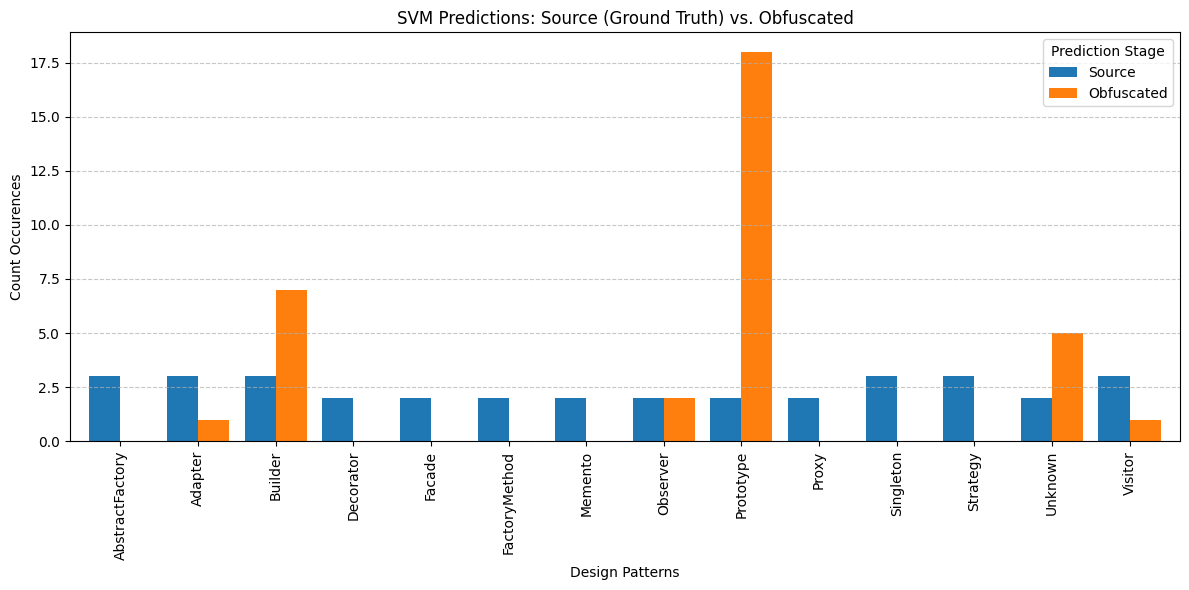

<Figure size 1200x600 with 0 Axes>

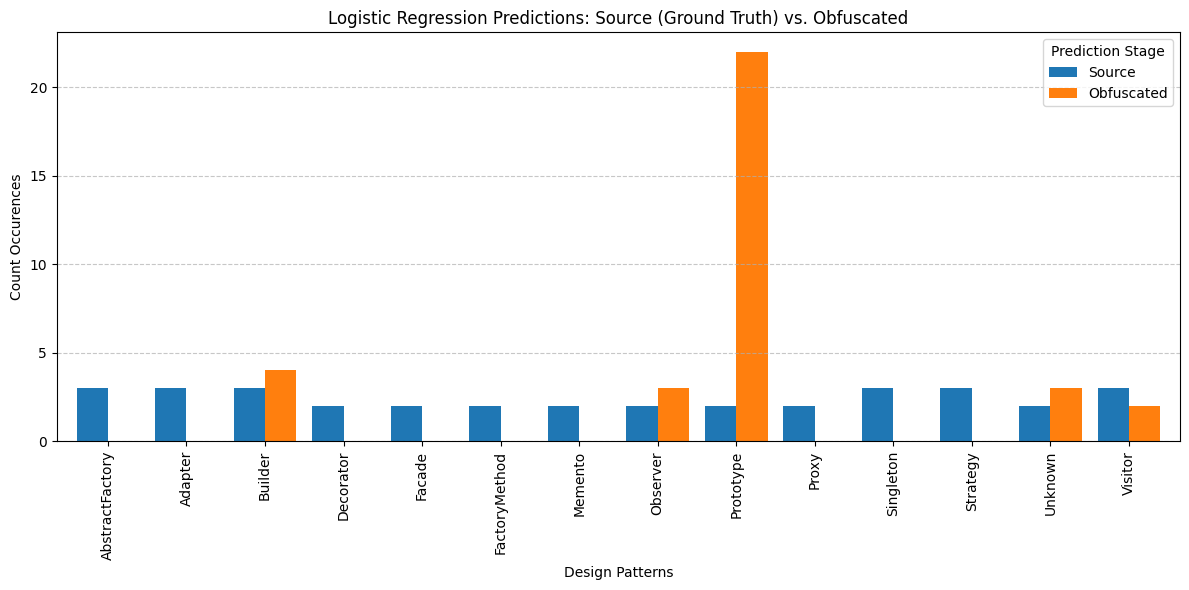

<Figure size 1200x600 with 0 Axes>

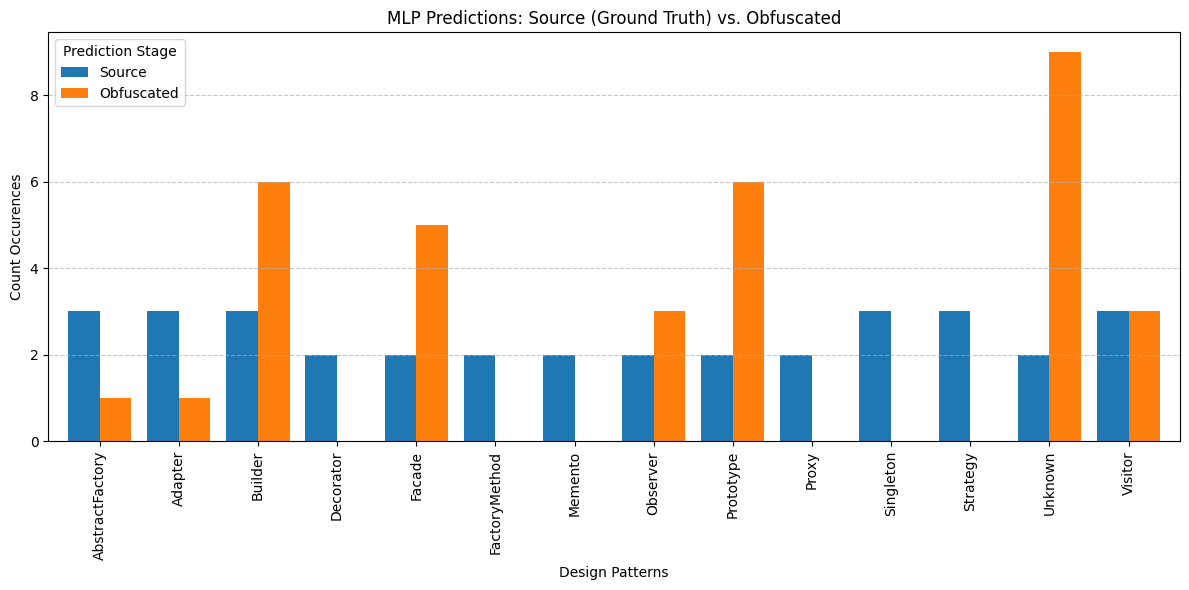

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
inference_data = pd.read_csv("inference_results_CV_7_34.csv")

# Prepare comparison data for SVM, Logistic Regression, and MLP
source_svm_predictions = inference_data['DesignPattern']
obfuscated_svm_predictions = inference_data['Obfuscated_SVM']

source_logistic_predictions = inference_data['DesignPattern']
obfuscated_logistic_predictions = inference_data['Obfuscated_Logistic Regression']

source_mlp_predictions = inference_data['DesignPattern']
obfuscated_mlp_predictions = inference_data['Obfuscated_MLP']

# Count occurrences for each model
svm_comparison = pd.DataFrame({
    'Source': source_svm_predictions.value_counts(),
    'Obfuscated': obfuscated_svm_predictions.value_counts()
}).fillna(0)

logistic_comparison = pd.DataFrame({
    'Source': source_logistic_predictions.value_counts(),
    'Obfuscated': obfuscated_logistic_predictions.value_counts()
}).fillna(0)

mlp_comparison = pd.DataFrame({
    'Source': source_mlp_predictions.value_counts(),
    'Obfuscated': obfuscated_mlp_predictions.value_counts()
}).fillna(0)

# Plot SVM comparison
plt.figure(figsize=(12, 6))
svm_comparison.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title("SVM Predictions: Source (Ground Truth) vs. Obfuscated")
plt.xlabel("Design Patterns")
plt.ylabel("Count Occurences")
plt.legend(title="Prediction Stage")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot Logistic Regression comparison
plt.figure(figsize=(12, 6))
logistic_comparison.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title("Logistic Regression Predictions: Source (Ground Truth) vs. Obfuscated")
plt.xlabel("Design Patterns")
plt.ylabel("Count Occurences")
plt.legend(title="Prediction Stage")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot MLP comparison
plt.figure(figsize=(12, 6))
mlp_comparison.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title("MLP Predictions: Source (Ground Truth) vs. Obfuscated")
plt.xlabel("Design Patterns")
plt.ylabel("Count Occurences")
plt.legend(title="Prediction Stage")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



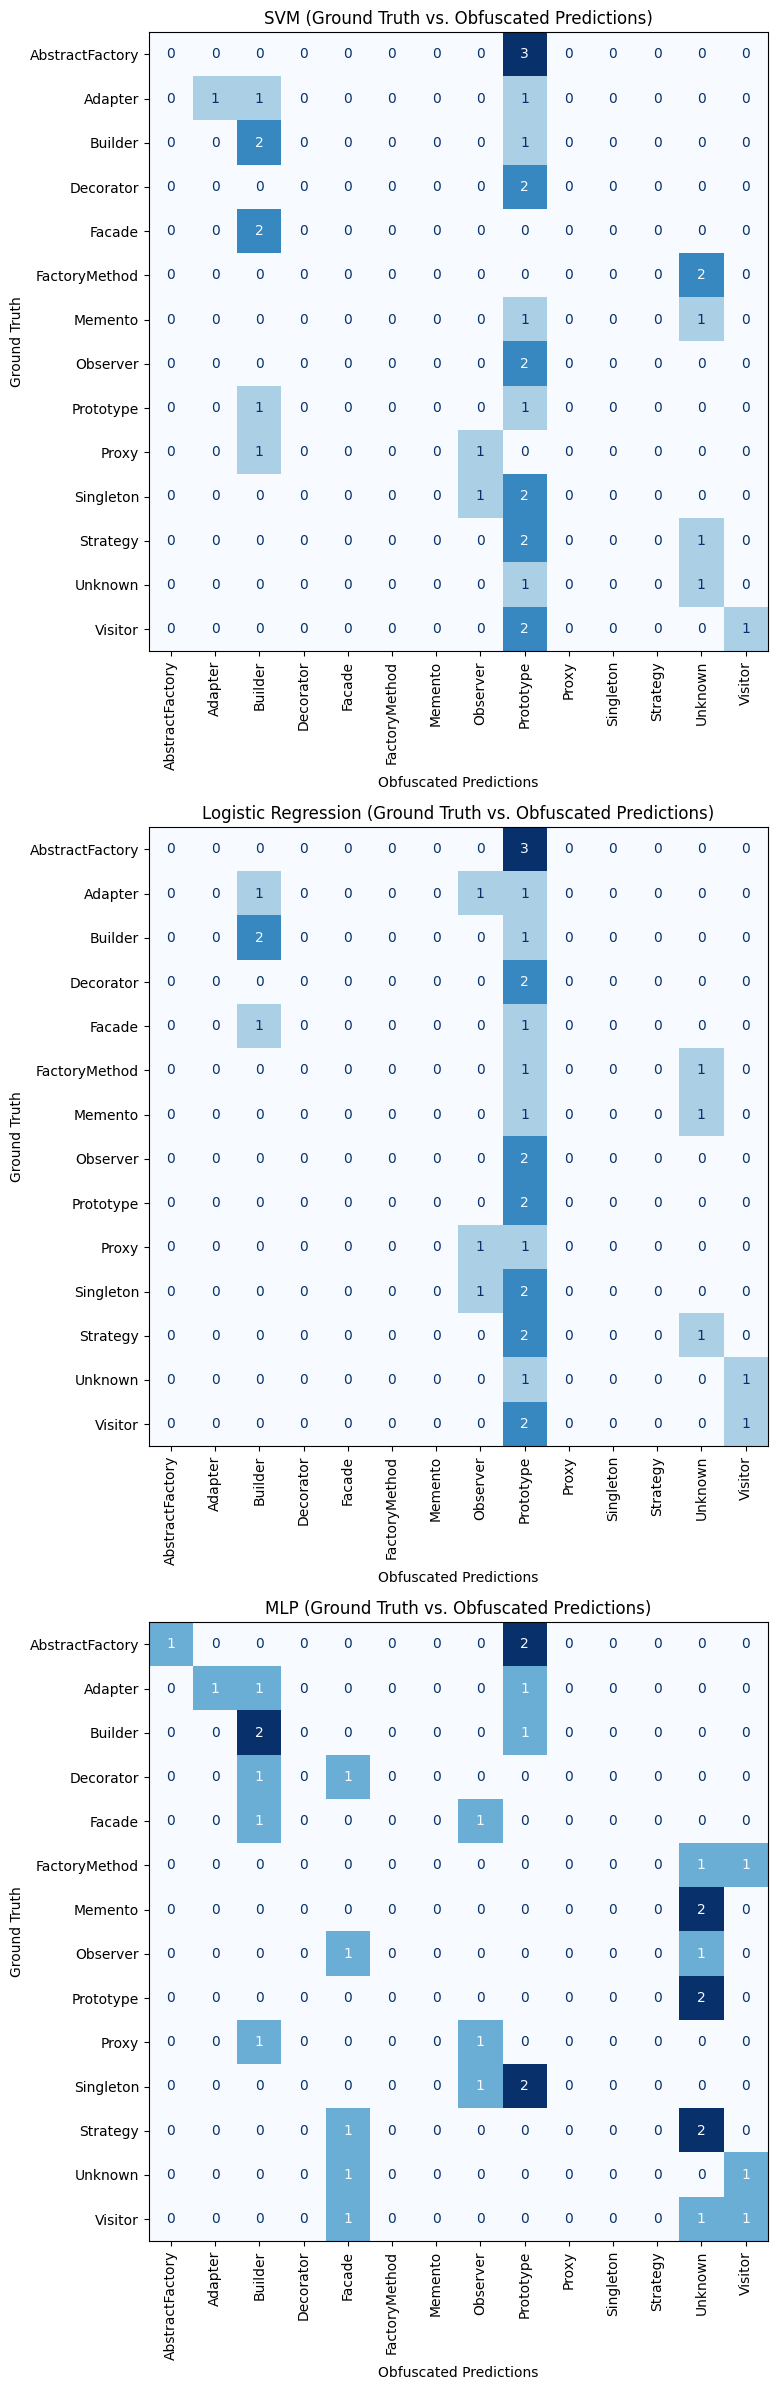

In [16]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_all_confusion_matrices_stacked_vertical(inference_data):
    # Create a figure with 3 rows, 1 column
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 24))
    
    # Classifier tuples: (title, source_col, obfuscated_col)
    classifiers = [
        ('SVM', 'DesignPattern', 'Obfuscated_SVM'),
        ('Logistic Regression', 'DesignPattern', 'Obfuscated_Logistic Regression'),
        ('MLP', 'DesignPattern', 'Obfuscated_MLP')
    ]
    
    for ax, (title, source_col, obf_col) in zip(axes, classifiers):
        # Determine the set of all labels present in either source or obfuscated predictions
        labels = sorted(list(set(inference_data[source_col]) | set(inference_data[obf_col])))
        
        # Compute confusion matrix
        cm = confusion_matrix(inference_data[source_col], inference_data[obf_col], labels=labels)
        
        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical', ax=ax, colorbar=False)
        
        # Customize each subplot's title and axis labels
        ax.set_title(f"{title} (Ground Truth vs. Obfuscated Predictions)")
        ax.set_xlabel("Obfuscated Predictions")
        ax.set_ylabel("Ground Truth")
    
    plt.tight_layout()
    plt.show()

# Example usage with your dataframe:
plot_all_confusion_matrices_stacked_vertical(inference_data)


Collecting workspace informationFiltering to most relevant informationHere is a structured list of your project folders and their contents, suitable for a README:

---

## Project Structure



In [ ]:
.
├── confusion_matrix_inf.png
├── cross valid_256.ipynb
├── datasetcreator.py
├── datasetcreator_obf_.py
├── DPD_Att_Classifier_256.csv
├── DPD_Att.csv
├── DPD_Att.rar
├── embeddings.py
├── feature_names.pkl
├── inference_results_CV_7_34.csv
├── label_classes.npy
├── model_t5p_256_Run.ipynb
├── obf_classifier_34.csv
├── run_inference_cross_valid_6.ipynb
├── codet5p/
│   └── codet5p-110m-embedding/
├── cross_valid_model_256/
│   ├── Logistic_Regression.pkl
│   ├── Multi-layer_Perceptron.pkl
│   └── Support_Vector_Machine.pkl
├── DPD_Att/
│   ├── 111/
│   └── ... (other subfolders and files)
├── obf_proguard_dpd/
│   └── ... (obfuscated Java project directories and files)
├── trained_models_256/
│   └── ... (trained model files)



### Folder Descriptions

- **codet5p/**  
  Contains CodeT5+ model files and embeddings.
  - `codet5p-110m-embedding/`: Pretrained embedding files for CodeT5+.

- **cross_valid_model_256/**  
  Contains trained classifier models for cross-validation.
  - `Logistic_Regression.pkl`: Trained Logistic Regression model.
  - `Multi-layer_Perceptron.pkl`: Trained MLP model.
  - `Support_Vector_Machine.pkl`: Trained SVM model.

- **DPD_Att/**  
  Contains Java source code, project folders, and related resources.
  - `111/`, ...: Subfolders for different Java projects or datasets.

- **obf_proguard_dpd/**  
  Contains obfuscated Java project directories and files, typically used for inference and evaluation.

- **trained_models_256/**  
  Stores additional trained model files (details depend on your workflow).

### Key Files

- run_inference_cross_valid_6.ipynb: Main notebook for running inference and evaluation.
- datasetcreator.py, datasetcreator_obf_.py: Scripts for dataset creation.
- embeddings.py: Code for generating embeddings from Java code.
- feature_names.pkl: Pickled feature names used by models.
- label_classes.npy: Numpy array of label classes for encoding/decoding.
- inference_results_CV_7_34.csv: CSV file with inference results.
- obf_classifier_34.csv: CSV with obfuscated classifier results.
- DPD_Att_Classifier_256.csv, DPD_Att.csv: Dataset CSVs.
- confusion_matrix_inf.png: Visualization of confusion matrix.
- model_t5p_256_Run.ipynb, `cross valid_256.ipynb`: Additional notebooks for model training and validation.

---

You can copy this structure into your README and expand on each section as needed.